# Music Analysis with a Bayesian Model

## Import libraries

In [1]:
import numpy as np
from numpy.random import choice, normal, dirichlet, beta, gamma, exponential, binomial
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

## Sticky Hierarchical Dirichlet Process Hidden Markov Model class
Our model is a non-parametric Bayesian model based on the Hidden Markov Model and a prior generated by a Hierarchical Dirichlet Process with 4 functions :
- Initialization of all hypterparameters, prior parameters, states,...
- Computation of log-likelihood
- Generation of the stick-breaking process with parameter gamma
- Blocked-Gibbs sampling running

In [12]:
class SHDPHMM:
    def __init__(self, data, alpha=1, kappa=1, gamma=1,
                 nu=2, sigma_a=2, sigma_b=2, L=20):
        
        # Initialize
        self.L = L
        self.alpha = alpha #parameter of the DP
        self.gamma = gamma #parameter of the DP
        
        self.data = data
        self.kappa = kappa * data.size #Sticky parameter
        self.T, self.n = self.data.shape

        #Random assignment of states
        self.state = choice(self.L, self.data.shape)
            
        #Distribution parameters of states assignment
        std = np.std(self.data)
        self.mu = normal(0, std, L)
        self.sigma = np.ones(L) * std

        # initialize the L clusters, compute mean and std.
        for i in range(L):
            idx = np.where(self.state == i)
            if idx[0].size:
                cluster = self.data[idx]
                self.mu[i] = np.mean(cluster)
                self.sigma[i] = np.std(cluster)
                
        # Stick breaking prior on betas
        stickbreaking = self.stick_breaking(gamma)
        self.betas = np.array([next(stickbreaking) for i in range(L)])

        # Matrix N with Njk number of transition from state j to k
        self.N = np.zeros((L, L))
        for t in range(1, self.T):
            for i in range(self.n):
                self.N[self.state[t-1, i], self.state[t, i]] += 1
                
        # Matrix with the mjk number of observation in cluster considering state k
        self.M = np.zeros(self.N.shape)
        # Initialization of the probabilities of transition
        self.PI = (self.N.T / (np.sum(self.N, axis=1) + 1e-7)).T
        
        # Hyperparameters
        self.nu = nu

        self.a = sigma_a
        self.b = sigma_b
        

    def loglikelihood(self, x, mu, sigma):
     #Compute log-likelihood.
        return -np.power((x - mu) / sigma,2) / 2 - np.log(sigma)
        
    def stick_breaking(self, gamma):
    #Stick breaking prior
        betas_save = 1
        while True:
            betas_k = beta(1, gamma) * betas_save
            betas_save -= betas_k
            yield betas_k
        
    # Sampling function
    def sampler(self):
    #Block gibbs sampler
        for subsequence in range(self.n):
            # Step 1: messages
            # Init messages to 1
            messages = np.zeros((self.T, self.L))
            messages[-1, :] = 1
            # With a backward loop, compute the messages for each k
            for t in range(self.T - 1, 0, -1):
                messages[t-1, :] = self.PI.dot(messages[t, :] * np.exp(self.loglikelihood(self.data[t, subsequence], self.mu, self.sigma)))
                messages[t-1, :] /= np.max(messages[t-1, :])

            # Step 2: states by MH algorithm
            for t in range(1, self.T):
                j = choice(self.L) #Random choice of state
                k = self.state[t, subsequence]  #Current state
                
                #Compute the logarithm of fk(yt) for the current state
                logprob_fk = (np.log(messages[t, k]) +
                                  np.log(self.PI[self.state[t-1, subsequence], k]) +
                                  self.loglikelihood(self.data[t-1, subsequence],
                                               self.mu[k],
                                               self.sigma[k]))
                #Computes the logarithm of fj(yt) for the random state picked              
                logprob_fj = (np.log(messages[t, j])+ 
                              np.log(self.PI[self.state[t-1, subsequence], j]) + 
                              self.loglikelihood(self.data[t-1, subsequence],
                                                 self.mu[j],
                                                 self.sigma[j]))
                            
                #Compares the two probabilities       
                if exponential(1) > (logprob_fk - logprob_fj):
                    #If the probability of having the state j is greater than the probability of having the state k
                    # We replace k by j at that time t
                    self.state[t, subsequence] = j
                    
                    #And make all the necessary adjustments in the matrix N 
                    #(that counts the number of state transitions)
                    self.N[self.state[t-1, subsequence], j] += 1
                    self.N[self.state[t-1, subsequence], k] -= 1
                    if t != (self.T-1):
                        self.N[k, self.state[t+1, subsequence]] -= 1 
                        self.N[j, self.state[t+1, subsequence]] += 1 
                    
        # Step 3: auxiliary variables
        # P contains the parameters for the Bernoulli distribution 
        P = np.tile(self.betas, (self.L, 1))*self.alpha + self.n
        # Adding the Kappa in diagonal
        np.fill_diagonal(P, np.diag(P) + self.kappa)
        P = 1 - self.n / P
        
        # Computes the M binomial distribution for each state transition
        for i in range(self.L):
            for j in range(self.L):
                self.M[i, j] = binomial(self.M[i, j], P[i, j])
        
        # Computes the override random variables
        w = np.array([binomial(self.M[i, i], self.kappa / (self.kappa + self.betas[i])) for i in range(self.L)])
        
        # Computes the number of considered states
        m_bar = np.sum(self.M, axis=0) - w
        
        # Step 4: betas and parameters of clusters
        self.betas = dirichlet(np.ones(self.L) * (self.gamma / self.L ) + m_bar)

        # Step 5: transition matrix
        self.PI =  np.tile(self.alpha * self.betas, (self.L, 1)) + self.N
        np.fill_diagonal(self.PI, np.diag(self.PI) + self.kappa)
            
        for i in range(self.L):
            # Derive PI from a Dirichlet 
            self.PI[i, :] = dirichlet(self.PI[i, :])
            
            # Find the clusters and update the parameters
            state_index = np.where(self.state == i)
            cluster = self.data[state_index]
            cardinal = cluster.size
            
            if cardinal:
                #If the cluster is not empty then we compute the posterior mean and variance
                meancluster = np.mean(cluster)
                self.mu[i] = meancluster / (self.nu / cardinal + 1)
                self.sigma[i] = (2 * self.b + (cardinal - 1) * np.var(cluster) + 
                                 cardinal * meancluster ** 2 / (self.nu + cardinal)) / (2 * self.a + cardinal - 1)
            else:
                #If the cluster is empty then we assign a value from the prior distribution
                self.mu[i] = normal(0, np.sqrt(self.nu))
                self.sigma[i] = 1 / gamma(self.a, self.b)

## Plot of simulated data

Text(0.5, 1.0, 'Simulated data')

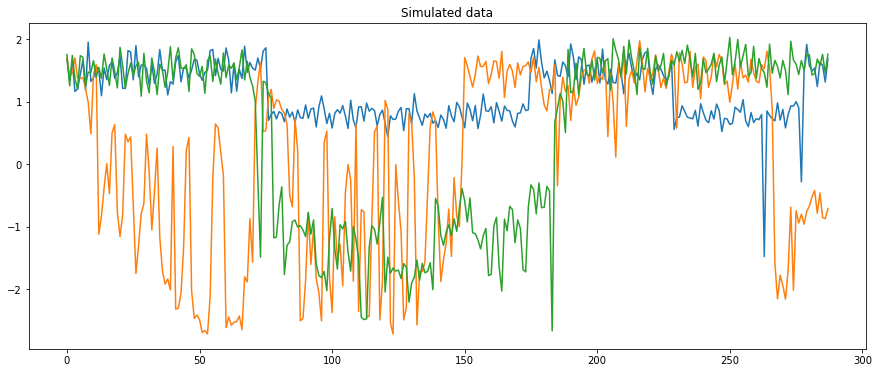

In [99]:
# First parameter prior
L = 30 #nb of states at the beginning

# Add the data
data = np.loadtxt("simulated_data.txt")
data = np.log10(data)
# kappa : Sticky parameter
model = SHDPHMM(data, kappa=10, L=L) 

# Plot of the data
plt.figure(figsize=(15,6))
plt.plot((data))
plt.title('Simulated data')

## Run Sampling

In [104]:
max_iter = 10000
for z in range(max_iter):
    print(str(z)+'/'+str(max_iter))
    model.sampler() 

0/10000
1/10000
2/10000


<ipython-input-12-5e1bb69a2d3d>:90: RuntimeWarning: divide by zero encountered in log
  np.log(self.PI[self.state[t-1, subsequence], j]) +
<ipython-input-12-5e1bb69a2d3d>:84: RuntimeWarning: divide by zero encountered in log
  np.log(self.PI[self.state[t-1, subsequence], k]) +
<ipython-input-12-5e1bb69a2d3d>:96: RuntimeWarning: invalid value encountered in double_scalars
  if exponential(1) > (logprob_fk - logprob_fj):


3/10000
4/10000
5/10000
6/10000
7/10000
8/10000
9/10000
10/10000
11/10000
12/10000
13/10000
14/10000
15/10000
16/10000
17/10000
18/10000
19/10000
20/10000
21/10000
22/10000
23/10000
24/10000
25/10000
26/10000
27/10000
28/10000
29/10000
30/10000
31/10000
32/10000
33/10000
34/10000
35/10000
36/10000
37/10000
38/10000
39/10000
40/10000
41/10000
42/10000
43/10000
44/10000
45/10000
46/10000
47/10000
48/10000
49/10000
50/10000
51/10000
52/10000
53/10000
54/10000
55/10000
56/10000
57/10000
58/10000
59/10000
60/10000
61/10000
62/10000
63/10000
64/10000
65/10000
66/10000
67/10000
68/10000
69/10000
70/10000
71/10000
72/10000
73/10000
74/10000
75/10000
76/10000
77/10000
78/10000
79/10000
80/10000
81/10000
82/10000
83/10000
84/10000
85/10000
86/10000
87/10000
88/10000
89/10000
90/10000
91/10000
92/10000
93/10000
94/10000
95/10000
96/10000
97/10000
98/10000
99/10000
100/10000
101/10000
102/10000
103/10000
104/10000
105/10000
106/10000
107/10000
108/10000
109/10000
110/10000
111/10000
112/10000
113/

<ipython-input-12-5e1bb69a2d3d>:89: RuntimeWarning: divide by zero encountered in log
  logprob_fj = (np.log(messages[t, j])+


466/10000
467/10000
468/10000
469/10000
470/10000
471/10000
472/10000
473/10000
474/10000
475/10000
476/10000
477/10000
478/10000
479/10000
480/10000
481/10000
482/10000
483/10000
484/10000
485/10000
486/10000
487/10000
488/10000
489/10000
490/10000
491/10000
492/10000
493/10000
494/10000
495/10000
496/10000
497/10000
498/10000
499/10000
500/10000
501/10000
502/10000
503/10000
504/10000
505/10000
506/10000
507/10000
508/10000
509/10000
510/10000
511/10000
512/10000
513/10000
514/10000
515/10000
516/10000
517/10000
518/10000
519/10000
520/10000
521/10000
522/10000
523/10000
524/10000
525/10000
526/10000
527/10000
528/10000
529/10000
530/10000
531/10000
532/10000
533/10000
534/10000
535/10000
536/10000
537/10000
538/10000
539/10000
540/10000
541/10000
542/10000
543/10000
544/10000
545/10000
546/10000
547/10000
548/10000
549/10000
550/10000
551/10000
552/10000
553/10000
554/10000
555/10000
556/10000
557/10000
558/10000
559/10000
560/10000
561/10000
562/10000
563/10000
564/10000
565/10000


1261/10000
1262/10000
1263/10000
1264/10000
1265/10000
1266/10000
1267/10000
1268/10000
1269/10000
1270/10000
1271/10000
1272/10000
1273/10000
1274/10000
1275/10000
1276/10000
1277/10000
1278/10000
1279/10000
1280/10000
1281/10000
1282/10000
1283/10000
1284/10000
1285/10000
1286/10000
1287/10000
1288/10000
1289/10000
1290/10000
1291/10000
1292/10000
1293/10000
1294/10000
1295/10000
1296/10000
1297/10000
1298/10000
1299/10000
1300/10000
1301/10000
1302/10000
1303/10000
1304/10000
1305/10000
1306/10000
1307/10000
1308/10000
1309/10000
1310/10000
1311/10000
1312/10000
1313/10000
1314/10000
1315/10000
1316/10000
1317/10000
1318/10000
1319/10000
1320/10000
1321/10000
1322/10000
1323/10000
1324/10000
1325/10000
1326/10000
1327/10000
1328/10000
1329/10000
1330/10000
1331/10000
1332/10000
1333/10000
1334/10000
1335/10000
1336/10000
1337/10000
1338/10000
1339/10000
1340/10000
1341/10000
1342/10000
1343/10000
1344/10000
1345/10000
1346/10000
1347/10000
1348/10000
1349/10000
1350/10000
1351/10000

2006/10000
2007/10000
2008/10000
2009/10000
2010/10000
2011/10000
2012/10000
2013/10000
2014/10000
2015/10000
2016/10000
2017/10000
2018/10000
2019/10000
2020/10000
2021/10000
2022/10000
2023/10000
2024/10000
2025/10000
2026/10000
2027/10000
2028/10000
2029/10000
2030/10000
2031/10000
2032/10000
2033/10000
2034/10000
2035/10000
2036/10000
2037/10000
2038/10000
2039/10000
2040/10000
2041/10000
2042/10000
2043/10000
2044/10000
2045/10000
2046/10000
2047/10000
2048/10000
2049/10000
2050/10000
2051/10000
2052/10000
2053/10000
2054/10000
2055/10000
2056/10000
2057/10000
2058/10000
2059/10000
2060/10000
2061/10000
2062/10000
2063/10000
2064/10000
2065/10000
2066/10000
2067/10000
2068/10000
2069/10000
2070/10000
2071/10000
2072/10000
2073/10000
2074/10000
2075/10000
2076/10000
2077/10000
2078/10000
2079/10000
2080/10000
2081/10000
2082/10000
2083/10000
2084/10000
2085/10000
2086/10000
2087/10000
2088/10000
2089/10000
2090/10000
2091/10000
2092/10000
2093/10000
2094/10000
2095/10000
2096/10000

2751/10000
2752/10000
2753/10000
2754/10000
2755/10000
2756/10000
2757/10000
2758/10000
2759/10000
2760/10000
2761/10000
2762/10000
2763/10000
2764/10000
2765/10000
2766/10000
2767/10000
2768/10000
2769/10000
2770/10000
2771/10000
2772/10000
2773/10000
2774/10000
2775/10000
2776/10000
2777/10000
2778/10000
2779/10000
2780/10000
2781/10000
2782/10000
2783/10000
2784/10000
2785/10000
2786/10000
2787/10000
2788/10000
2789/10000
2790/10000
2791/10000
2792/10000
2793/10000
2794/10000
2795/10000
2796/10000
2797/10000
2798/10000
2799/10000
2800/10000
2801/10000
2802/10000
2803/10000
2804/10000
2805/10000
2806/10000
2807/10000
2808/10000
2809/10000
2810/10000
2811/10000
2812/10000
2813/10000
2814/10000
2815/10000
2816/10000
2817/10000
2818/10000
2819/10000
2820/10000
2821/10000
2822/10000
2823/10000
2824/10000
2825/10000
2826/10000
2827/10000
2828/10000
2829/10000
2830/10000
2831/10000
2832/10000
2833/10000
2834/10000
2835/10000
2836/10000
2837/10000
2838/10000
2839/10000
2840/10000
2841/10000

3499/10000
3500/10000
3501/10000
3502/10000
3503/10000
3504/10000
3505/10000
3506/10000
3507/10000
3508/10000
3509/10000
3510/10000
3511/10000
3512/10000
3513/10000
3514/10000
3515/10000
3516/10000
3517/10000
3518/10000
3519/10000
3520/10000
3521/10000
3522/10000
3523/10000
3524/10000
3525/10000
3526/10000
3527/10000
3528/10000
3529/10000
3530/10000
3531/10000
3532/10000
3533/10000
3534/10000
3535/10000
3536/10000
3537/10000
3538/10000
3539/10000
3540/10000
3541/10000
3542/10000
3543/10000
3544/10000
3545/10000
3546/10000
3547/10000
3548/10000
3549/10000
3550/10000
3551/10000
3552/10000
3553/10000
3554/10000
3555/10000
3556/10000
3557/10000
3558/10000
3559/10000
3560/10000
3561/10000
3562/10000
3563/10000
3564/10000
3565/10000
3566/10000
3567/10000
3568/10000
3569/10000
3570/10000
3571/10000
3572/10000
3573/10000
3574/10000
3575/10000
3576/10000
3577/10000
3578/10000
3579/10000
3580/10000
3581/10000
3582/10000
3583/10000
3584/10000
3585/10000
3586/10000
3587/10000
3588/10000
3589/10000

4247/10000
4248/10000
4249/10000
4250/10000
4251/10000
4252/10000
4253/10000
4254/10000
4255/10000
4256/10000
4257/10000
4258/10000
4259/10000
4260/10000
4261/10000
4262/10000
4263/10000
4264/10000
4265/10000
4266/10000
4267/10000
4268/10000
4269/10000
4270/10000
4271/10000
4272/10000
4273/10000
4274/10000
4275/10000
4276/10000
4277/10000
4278/10000
4279/10000
4280/10000
4281/10000
4282/10000
4283/10000
4284/10000
4285/10000
4286/10000
4287/10000
4288/10000
4289/10000
4290/10000
4291/10000
4292/10000
4293/10000
4294/10000
4295/10000
4296/10000
4297/10000
4298/10000
4299/10000
4300/10000
4301/10000
4302/10000
4303/10000
4304/10000
4305/10000
4306/10000
4307/10000
4308/10000
4309/10000
4310/10000
4311/10000
4312/10000
4313/10000
4314/10000
4315/10000
4316/10000
4317/10000
4318/10000
4319/10000
4320/10000
4321/10000
4322/10000
4323/10000
4324/10000
4325/10000
4326/10000
4327/10000
4328/10000
4329/10000
4330/10000
4331/10000
4332/10000
4333/10000
4334/10000
4335/10000
4336/10000
4337/10000

4994/10000
4995/10000
4996/10000
4997/10000
4998/10000
4999/10000
5000/10000
5001/10000
5002/10000
5003/10000
5004/10000
5005/10000
5006/10000
5007/10000
5008/10000
5009/10000
5010/10000
5011/10000
5012/10000
5013/10000
5014/10000
5015/10000
5016/10000
5017/10000
5018/10000
5019/10000
5020/10000
5021/10000
5022/10000
5023/10000
5024/10000
5025/10000
5026/10000
5027/10000
5028/10000
5029/10000
5030/10000
5031/10000
5032/10000
5033/10000
5034/10000
5035/10000
5036/10000
5037/10000
5038/10000
5039/10000
5040/10000
5041/10000
5042/10000
5043/10000
5044/10000
5045/10000
5046/10000
5047/10000
5048/10000
5049/10000
5050/10000
5051/10000
5052/10000
5053/10000
5054/10000
5055/10000
5056/10000
5057/10000
5058/10000
5059/10000
5060/10000
5061/10000
5062/10000
5063/10000
5064/10000
5065/10000
5066/10000
5067/10000
5068/10000
5069/10000
5070/10000
5071/10000
5072/10000
5073/10000
5074/10000
5075/10000
5076/10000
5077/10000
5078/10000
5079/10000
5080/10000
5081/10000
5082/10000
5083/10000
5084/10000

5741/10000
5742/10000
5743/10000
5744/10000
5745/10000
5746/10000
5747/10000
5748/10000
5749/10000
5750/10000
5751/10000
5752/10000
5753/10000
5754/10000
5755/10000
5756/10000
5757/10000
5758/10000
5759/10000
5760/10000
5761/10000
5762/10000
5763/10000
5764/10000
5765/10000
5766/10000
5767/10000
5768/10000
5769/10000
5770/10000
5771/10000
5772/10000
5773/10000
5774/10000
5775/10000
5776/10000
5777/10000
5778/10000
5779/10000
5780/10000
5781/10000
5782/10000
5783/10000
5784/10000
5785/10000
5786/10000
5787/10000
5788/10000
5789/10000
5790/10000
5791/10000
5792/10000
5793/10000
5794/10000
5795/10000
5796/10000
5797/10000
5798/10000
5799/10000
5800/10000
5801/10000
5802/10000
5803/10000
5804/10000
5805/10000
5806/10000
5807/10000
5808/10000
5809/10000
5810/10000
5811/10000
5812/10000
5813/10000
5814/10000
5815/10000
5816/10000
5817/10000
5818/10000
5819/10000
5820/10000
5821/10000
5822/10000
5823/10000
5824/10000
5825/10000
5826/10000
5827/10000
5828/10000
5829/10000
5830/10000
5831/10000

6489/10000
6490/10000
6491/10000
6492/10000
6493/10000
6494/10000
6495/10000
6496/10000
6497/10000
6498/10000
6499/10000
6500/10000
6501/10000
6502/10000
6503/10000
6504/10000
6505/10000
6506/10000
6507/10000
6508/10000
6509/10000
6510/10000
6511/10000
6512/10000
6513/10000
6514/10000
6515/10000
6516/10000
6517/10000
6518/10000
6519/10000
6520/10000
6521/10000
6522/10000
6523/10000
6524/10000
6525/10000
6526/10000
6527/10000
6528/10000
6529/10000
6530/10000
6531/10000
6532/10000
6533/10000
6534/10000
6535/10000
6536/10000
6537/10000
6538/10000
6539/10000
6540/10000
6541/10000
6542/10000
6543/10000
6544/10000
6545/10000
6546/10000
6547/10000
6548/10000
6549/10000
6550/10000
6551/10000
6552/10000
6553/10000
6554/10000
6555/10000
6556/10000
6557/10000
6558/10000
6559/10000
6560/10000
6561/10000
6562/10000
6563/10000
6564/10000
6565/10000
6566/10000
6567/10000
6568/10000
6569/10000
6570/10000
6571/10000
6572/10000
6573/10000
6574/10000
6575/10000
6576/10000
6577/10000
6578/10000
6579/10000

7237/10000
7238/10000
7239/10000
7240/10000
7241/10000
7242/10000
7243/10000
7244/10000
7245/10000
7246/10000
7247/10000
7248/10000
7249/10000
7250/10000
7251/10000
7252/10000
7253/10000
7254/10000
7255/10000
7256/10000
7257/10000
7258/10000
7259/10000
7260/10000
7261/10000
7262/10000
7263/10000
7264/10000
7265/10000
7266/10000
7267/10000
7268/10000
7269/10000
7270/10000
7271/10000
7272/10000
7273/10000
7274/10000
7275/10000
7276/10000
7277/10000
7278/10000
7279/10000
7280/10000
7281/10000
7282/10000
7283/10000
7284/10000
7285/10000
7286/10000
7287/10000
7288/10000
7289/10000
7290/10000
7291/10000
7292/10000
7293/10000
7294/10000
7295/10000
7296/10000
7297/10000
7298/10000
7299/10000
7300/10000
7301/10000
7302/10000
7303/10000
7304/10000
7305/10000
7306/10000
7307/10000
7308/10000
7309/10000
7310/10000
7311/10000
7312/10000
7313/10000
7314/10000
7315/10000
7316/10000
7317/10000
7318/10000
7319/10000
7320/10000
7321/10000
7322/10000
7323/10000
7324/10000
7325/10000
7326/10000
7327/10000

7984/10000
7985/10000
7986/10000
7987/10000
7988/10000
7989/10000
7990/10000
7991/10000
7992/10000
7993/10000
7994/10000
7995/10000
7996/10000
7997/10000
7998/10000
7999/10000
8000/10000
8001/10000
8002/10000
8003/10000
8004/10000
8005/10000
8006/10000
8007/10000
8008/10000
8009/10000
8010/10000
8011/10000
8012/10000
8013/10000
8014/10000
8015/10000
8016/10000
8017/10000
8018/10000
8019/10000
8020/10000
8021/10000
8022/10000
8023/10000
8024/10000
8025/10000
8026/10000
8027/10000
8028/10000
8029/10000
8030/10000
8031/10000
8032/10000
8033/10000
8034/10000
8035/10000
8036/10000
8037/10000
8038/10000
8039/10000
8040/10000
8041/10000
8042/10000
8043/10000
8044/10000
8045/10000
8046/10000
8047/10000
8048/10000
8049/10000
8050/10000
8051/10000
8052/10000
8053/10000
8054/10000
8055/10000
8056/10000
8057/10000
8058/10000
8059/10000
8060/10000
8061/10000
8062/10000
8063/10000
8064/10000
8065/10000
8066/10000
8067/10000
8068/10000
8069/10000
8070/10000
8071/10000
8072/10000
8073/10000
8074/10000

8730/10000
8731/10000
8732/10000
8733/10000
8734/10000
8735/10000
8736/10000
8737/10000
8738/10000
8739/10000
8740/10000
8741/10000
8742/10000
8743/10000
8744/10000
8745/10000
8746/10000
8747/10000
8748/10000
8749/10000
8750/10000
8751/10000
8752/10000
8753/10000
8754/10000
8755/10000
8756/10000
8757/10000
8758/10000
8759/10000
8760/10000
8761/10000
8762/10000
8763/10000
8764/10000
8765/10000
8766/10000
8767/10000
8768/10000
8769/10000
8770/10000
8771/10000
8772/10000
8773/10000
8774/10000
8775/10000
8776/10000
8777/10000
8778/10000
8779/10000
8780/10000
8781/10000
8782/10000
8783/10000
8784/10000
8785/10000
8786/10000
8787/10000
8788/10000
8789/10000
8790/10000
8791/10000
8792/10000
8793/10000
8794/10000
8795/10000
8796/10000
8797/10000
8798/10000
8799/10000
8800/10000
8801/10000
8802/10000
8803/10000
8804/10000
8805/10000
8806/10000
8807/10000
8808/10000
8809/10000
8810/10000
8811/10000
8812/10000
8813/10000
8814/10000
8815/10000
8816/10000
8817/10000
8818/10000
8819/10000
8820/10000

9477/10000
9478/10000
9479/10000
9480/10000
9481/10000
9482/10000
9483/10000
9484/10000
9485/10000
9486/10000
9487/10000
9488/10000
9489/10000
9490/10000
9491/10000
9492/10000
9493/10000
9494/10000
9495/10000
9496/10000
9497/10000
9498/10000
9499/10000
9500/10000
9501/10000
9502/10000
9503/10000
9504/10000
9505/10000
9506/10000
9507/10000
9508/10000
9509/10000
9510/10000
9511/10000
9512/10000
9513/10000
9514/10000
9515/10000
9516/10000
9517/10000
9518/10000
9519/10000
9520/10000
9521/10000
9522/10000
9523/10000
9524/10000
9525/10000
9526/10000
9527/10000
9528/10000
9529/10000
9530/10000
9531/10000
9532/10000
9533/10000
9534/10000
9535/10000
9536/10000
9537/10000
9538/10000
9539/10000
9540/10000
9541/10000
9542/10000
9543/10000
9544/10000
9545/10000
9546/10000
9547/10000
9548/10000
9549/10000
9550/10000
9551/10000
9552/10000
9553/10000
9554/10000
9555/10000
9556/10000
9557/10000
9558/10000
9559/10000
9560/10000
9561/10000
9562/10000
9563/10000
9564/10000
9565/10000
9566/10000
9567/10000

## Plot transition matrix

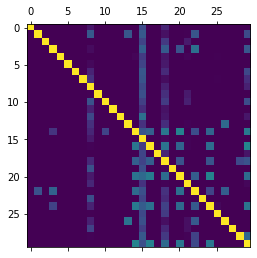

In [105]:
plt.matshow(model.PI,norm=PowerNorm(0.2, 0, 1), vmin=0, vmax=0.1, aspect='auto')

## Plot estimated sample path
The estimated sample paths corresponds to the mean of observations on the considered state

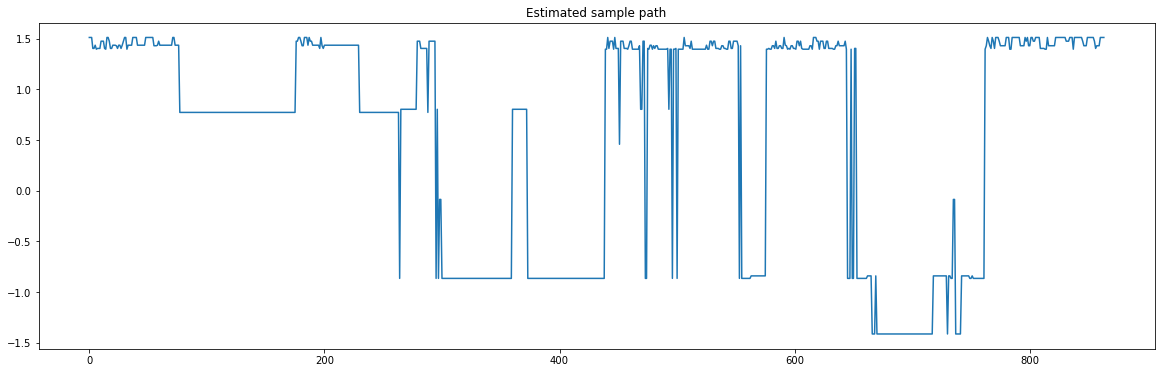

In [117]:
# ESTIMATED SAMPLE PATH
pathss = []
for h in range(model.n):
    paths = np.zeros(model.data.shape[0])
    for i, mu in enumerate(model.mu):
        # Mu = mean on the state i
        paths[np.where(model.state[:, h] == i)] = mu
    pathss.append(paths)
#Concatenate paths
pathsplot = np.concatenate(pathss)
#Plot paths
plt.figure(figsize=(20,6))
plt.title('Estimated sample path')
plt.plot(pathsplot)

Text(0.5, 1.0, 'Transition Matrix')

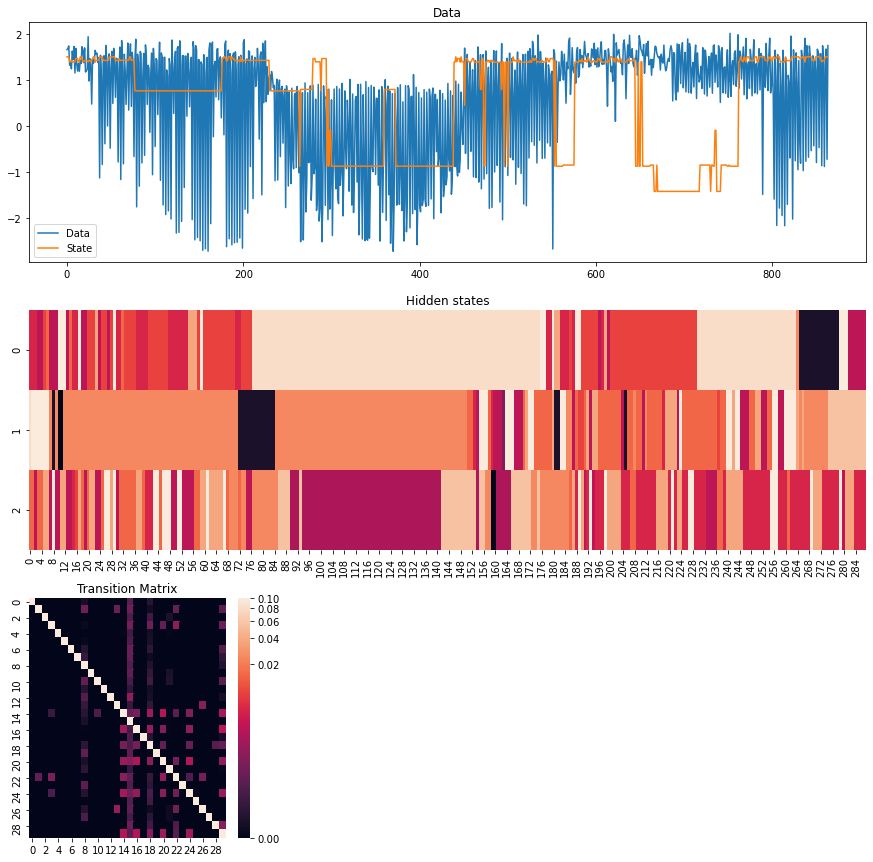

In [116]:
import seaborn as sns
states = model.state
paths_plot = np.ravel(pathss)
plt.figure(2, figsize=(15,15))
ax1 = plt.subplot(311)
plt.plot(range(data.size), np.ravel(data))
plt.plot(range(data.size), paths_plot)
ax1.set_title("Data")
plt.legend(['Data','State','DataSeq3','StateMeanPath'])

ax2 = plt.subplot(312)
sns.heatmap(states.T, ax=ax2, cbar=False)
ax2.set_title("Hidden states")

ax3 = plt.subplot(337)
sns.heatmap(model.PI,norm=PowerNorm(0.2, 0, 1), vmin=0, vmax=0.1, ax=ax3)
ax3.set_title('Transition Matrix')

